In [3]:
# Import all modules
%matplotlib inline
import random
import pylab
import pickle as pkl
from PIL import Image
import numpy as np
import pandas as pd
from lasagne import layers
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from sklearn.cross_validation import train_test_split
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


In [4]:
# Load data set
root = '/home/shraddha/Project/ff/project_11/scripts'
data = pd.read_csv(root + '/LISTFILE.txt', sep = ' ', header = None)

In [8]:
root = '/home/shraddha/Project/ff/project_11/datasets/English/'
from scipy.misc import imread as ims
img = ims(root + data[0][0])

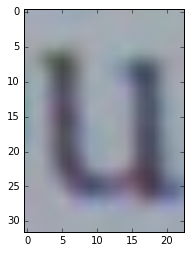

In [9]:
pylab.imshow(img)
pylab.show()

In [10]:
data[1].count()

7705

In [11]:
root = '/home/shraddha/Project/ff/project_11/datasets/English/'
data_x = np.zeros((7705, 1, 32, 32))
data_y = data[1]
from scipy.misc import imread, imresize
for idx, path in enumerate(data[0]):
    img = imread(root + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')
train1_x, test1_x, train1_y, test1_y = train_test_split(data_x, data_y, test_size = 0.2)

In [12]:
print train1_x.shape, test1_x.shape, train1_y.shape, test1_y.shape

(6164, 1, 32, 32) (1541, 1, 32, 32) (6164,) (1541,)


In [13]:
# preprocess
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

test1_x /= test1_x.std(axis = None)
test1_x -= test1_x.mean()

In [14]:
X = train1_x
y = train1_y

In [15]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (3, 3),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (2, 2),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.2,
    conv3_num_filters = 100, conv3_filter_size = (7, 7),
    hidden4_num_units = 100,
    output_num_units = 62, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 100),
    batch_iterator_test = BatchIterator(batch_size = 100),

    update=nesterov_momentum,
    update_learning_rate = 0.003,
    update_momentum = 0.9,

    use_label_encoder = True,
    regression = False,
    max_epochs = 30,
    verbose = 1,
)

In [21]:
# train and test nn
net.fit(X,y)
pred = net.predict(test1_x)

# Neural Network with 338638 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x32x32
  1  conv1     32x30x30
  2  pool1     32x15x15
  3  dropout1  32x15x15
  4  conv2     64x14x14
  5  pool2     64x7x7
  6  dropout2  64x7x7
  7  conv3     100x1x1
  8  hidden4   100
  9  output    62



In [16]:
root = '/home/shraddha/Project/ff/project_11/datasets/'

import re, collections

def words(text): return re.findall('[a-z]+', text.lower()) 

def train(features):
    model = collections.defaultdict(lambda: 1 
                                   )
    for f in features:
        model[f] += 1
    return model

NWORDS = train(words(file(root + 'big.txt').read()))

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
   splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
   deletes    = [a + b[1:] for a, b in splits if b]
   transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
   replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
   inserts    = [a + c + b     for a, b in splits for c in alphabet]
   return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words): return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return sorted(candidates,  key=NWORDS.get, reverse = True)

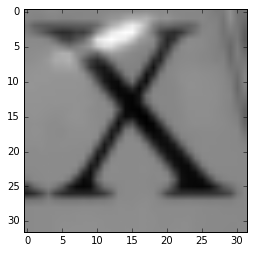

In [17]:
# Visualizing test set
# t -> 26, E -> 47, S -> 89, T -> 55
img = test1_x[26]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()
pylab.show()

In [18]:
tester = np.zeros((4, 1, 32, 32))
tester[0, ...] = test1_x[26]
tester[1, ...] = test1_x[47]
tester[2, ...] = test1_x[89]
tester[3, ...] = test1_x[55]

In [19]:
tester = tester.astype('float32')

In [20]:
preder = net.predict(tester)

AttributeError: 'NeuralNet' object has no attribute 'predict_iter_'

In [25]:
preder.shape

(4,)

In [26]:
preder

array([21, 12, 18, 48])

In [27]:
def classer(arrayer):
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    classer_array = []
    for i in range(len(arrayer)):
        if (0 <= arrayer[i] < 10):
            classer_array.append(arrayer[i])
        elif (10 <= arrayer[i] < 36) :
            classer_array.append(alphabet[arrayer[i] - 10].upper())
        elif (36 <= arrayer[i] < 62):
            classer_array.append(alphabet[arrayer[i] - 36])
        else : 
            print 'Is the array correct!?'
    return classer_array

In [28]:
real_pred = classer(preder)

In [29]:
letter_stream = ''.join(real_pred).lower()

In [30]:
letter_stream

'lcim'

In [2]:
choices=correct(letter_stream)

NameError: name 'correct' is not defined

In [33]:
print choices

['clim', 'lcm']


In [34]:
print process.extractOne(letter_stream, choices)

('lcm', 86)


In [35]:
print process.extract(letter_stream, choices)

[('lcm', 86), ('clim', 75)]


In [1]:
#Threshold=90
for i in choices:
    fuzz.ratio(i, letter_stream)
    if(fuzz.ratio(i, letter_stream)>90):
        print fuzz.ratio(i, letter_stream)

NameError: name 'choices' is not defined

In [ ]:
for i in words:
    R=fuzz.ratio(i, letter_stream)
    if(R>90):
         print R